Machine learning INFO284 Group Exam: Gruppemedlemmer: 275,159,269,223

# Task 1 Machine learning on tabular mushrooms

Here we import all of our necessary libraries. Sklearn for predicitive data analysis, classification, regression, clustering and more. Pandas for data analysis and data manipulation and so forth. We use numpy for numerical computing, this provides tools for working with arrays and matrices and other numerical data. Dython we use for work on nominal data. Matplotlib is used for data visualization, seaborn is used for informative and aestetic plots.

In [1]:
import pandas as pd 
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder 
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from dython.nominal import associations
import matplotlib.pyplot as plt
from dython import nominal



from sklearn.model_selection import train_test_split
pd.options.display.max_columns = 500
pd.set_option('display.max_rows', 200)

## Loading Data

In [2]:
df = pd.read_table('agaricus-lepiota.csv', delimiter=',', header=None)
df.head()

0  1  2  3  4  5  6  7  8  9  10 11 12 13 14 15 16 17 18 19 20 21 22
0  p  x  s  n  t  p  f  c  n  k  e  e  s  s  w  w  p  w  o  p  k  s  u
1  e  x  s  y  t  a  f  c  b  k  e  c  s  s  w  w  p  w  o  p  n  n  g
2  e  b  s  w  t  l  f  c  b  n  e  c  s  s  w  w  p  w  o  p  n  n  m
3  p  x  y  w  t  p  f  c  n  n  e  e  s  s  w  w  p  w  o  p  k  s  u
4  e  x  s  g  f  n  f  w  b  k  t  e  s  s  w  w  p  w  o  e  n  a  g

Pre-processing

We check for any duplicates in our dataframe ("df"), this is important due to the fact that duplicates can inflate performance by overfitting. However, we read that there are 0 duplicates in our 8124 rows.

In [3]:
duplicates = df.duplicated().sum()
count = df.shape[0]
print(f'{duplicates} duplicate rows in {count} rows')

0 duplicate rows in 8124 rows


In [4]:
column_labels = [
    'class', 'cap shape', 'cap surface', 'cap color', 'bruised', 'odor',
    'gill attachment', 'gill spacing', 'gill size', 'gill color', 
    'stalk shape', 'stalk root', 'stalk surface above ring',
    'stalk surface below ring', 'stalk color above ring',
    'stalk color below ring', 'veil type', 'veil color', 'ring number',
    'ring type', 'spore print color', 'population', 'habitat'
]

df.columns = column_labels

We use the classifications from the "agaricus-lepiota" text file. We can now see how the "1" have turned into "class", and the other numbers have turned into other descriptive words.


In [5]:
df.head()

class cap shape cap surface cap color bruised odor gill attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill spacing gill size gill color stalk shape stalk root  \
0            c         n          k           e          e   
1            c         b          k           e          c   
2            c         b          n           e          c   
3            c         n          n           e          e   
4            w         b          k           t          e   

  stalk surface above ring stalk surface below ring stalk color above ring  \
0                        s                        s                      w   
1                        s                        s                      w   
2                        s                        s                      w   
3                        s                        s                      w   
4                        s                        s                      w   

  stalk color below ring veil type veil color ring number ring type  \
0                      w         p          w           o         p   
1                      w         p          w           o         p   
2                      w         p          w           o         p   
3                      w         p          w           o         p   
4                      w         p          w           o         e   

  spore print color population habitat  
0                 k          s       u  
1                 n          n       g  
2                 n          n       m  
3                 k          s       u  
4                 n          a       g

In [6]:
df['class'].replace(['e', 'p'], [0, 1], inplace=True)
df['stalk root'].value_counts()

b    3776
?    2480
e    1120
c     556
r     192
Name: stalk root, dtype: int64

This code replaces the values in 'class'. It replaces 'e' (edible) with 0 and 'p' (poisonous) with 1. We change them from categorical to numerical.
We see that there are alot of the mushrooms that have "stalk root" type "?", 30.5% of the mushrooms have "?" as its stalk root.


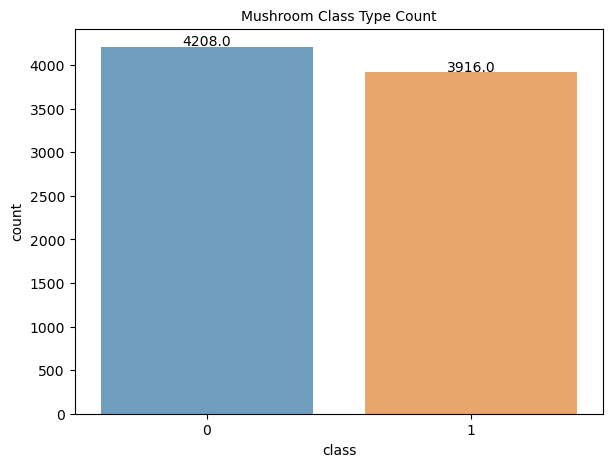

In [7]:
plt.rcParams['figure.figsize']=15,5
plt.subplot(121)
plt.title('Mushroom Class Type Count', fontsize=10)
s = sns.countplot(x = "class", data = df, alpha=0.7)
for p in s.patches:
    s.annotate(format(p.get_height(), '.1f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 4), 
                textcoords = 'offset points')

Here we show the count difference between edible (0) and poisonous (1) mushrooms. We see that the dataset is very balanced between classes.


In [8]:
df['veil type'].value_counts()

p    8124
Name: veil type, dtype: int64

We count the veil type as well and find that all the mushrooms have the type. We therefore decide to drop it, as it wont impact performance.

In [9]:
df.columns.drop(['stalk root'])
df.columns.drop(['veil type'])

Index(['class', 'cap shape', 'cap surface', 'cap color', 'bruised', 'odor',
       'gill attachment', 'gill spacing', 'gill size', 'gill color',
       'stalk shape', 'stalk root', 'stalk surface above ring',
       'stalk surface below ring', 'stalk color above ring',
       'stalk color below ring', 'veil color', 'ring number', 'ring type',
       'spore print color', 'population', 'habitat'],
      dtype='object')

In [10]:
print(len(df.columns))

23


Further, we calculate the Theil's U statistic between the target ('class') and each feature in the DataFrame.

Theil's U is a measure of the strength of association between two categorical variables. It ranges from 0 to 1, where 0 indicates no association and 1 indicates a strong association. This is useful for identifying which features are most informative for predicting the target variable.

Finally, we create a heatmap visualization of the results using the sns.heatmap() function from the Seaborn library. The heatmap is annotated with the correlation for each feature and target pair.


/home/yarkin/anaconda3/lib/python3.9/site-packages/dython/nominal.py:219: RuntimeWarning: Rounded U = -1.6032076067317889e-16 to 0.0. This is probably due to floating point precision issues.
  warnings.warn(


<Axes: >

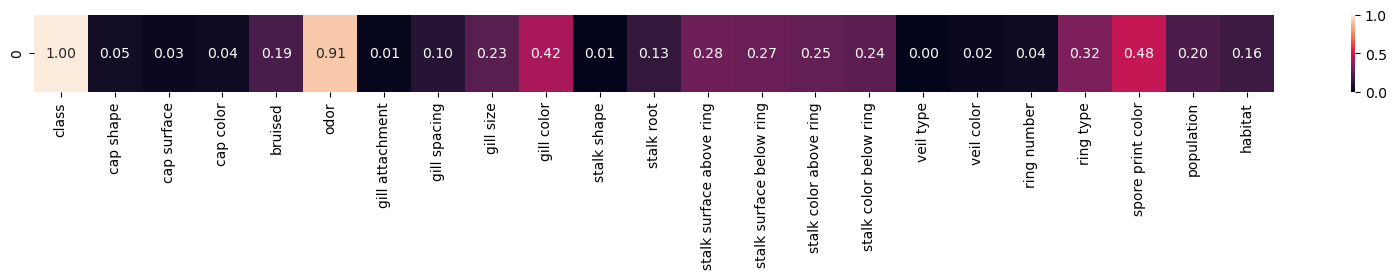

In [11]:
theil_data = [[nominal.theils_u(df["class"], df[col]) for col in df]]
plt.figure(figsize=(20,1))
sns.heatmap(theil_data, annot=True, fmt='.2f', xticklabels=df.columns)

From this heatmap we can deduce that odor has a very close correlation to the precense of poison in the mushroom. Now we can take a closer look at odor to see how it correlates with the presence of poison.

In [12]:
sns.set(rc={'figure.figsize':(15,8)})
ax=sns.countplot(x='odor',hue='class',data=df)
for p in ax.patches:
    patch_height = p.get_height()
    if np.isnan(patch_height):
        patch_height = 0    
    ax.annotate('{}'.format(int(patch_height)), (p.get_x()+0.05, patch_height+10))
plt.show()

In this graph we see that the presence of "odor f", meaning foul odor guarantees the presence of poison, there are a multitude of other smells that also guarantees poison. However "odor n", meaning no odor is weighted towards non-poisonous, however there are 120 instances of mushrooms that smell nothing that also are poisonous.

One-Hot Encoding

This code snippet performs one-hot encoding for all categorical features in the dataframe, except for the target variable column "class".

This process is done so that we convert categorical features into a numerical format, here we avoid assigning an arbitrary ordering to the categorical values that might not be meaningful for the model. And as there is no natural ordering for things like 'cap shape' or colors one-hot is well suited for this task.


In [13]:
for column in df.columns.drop(["class"]):
    dummies = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df, dummies], axis=1)
    df.drop([column], axis=1, inplace=True)

In [14]:
df.head()

class  cap shape_b  cap shape_c  cap shape_f  cap shape_k  cap shape_s  \
0      1            0            0            0            0            0   
1      0            0            0            0            0            0   
2      0            1            0            0            0            0   
3      1            0            0            0            0            0   
4      0            0            0            0            0            0   

   cap shape_x  cap surface_f  cap surface_g  cap surface_s  cap surface_y  \
0            1              0              0              1              0   
1            1              0              0              1              0   
2            0              0              0              1              0   
3            1              0              0              0              1   
4            1              0              0              1              0   

   cap color_b  cap color_c  cap color_e  cap color_g  cap color_n  \
0            0            0            0            0            1   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            1            0   

   cap color_p  cap color_r  cap color_u  cap color_w  cap color_y  bruised_f  \
0            0            0            0            0            0          0   
1            0            0            0            0            1          0   
2            0            0            0            1            0          0   
3            0            0            0            1            0          0   
4            0            0            0            0            0          1   

   bruised_t  odor_a  odor_c  odor_f  odor_l  odor_m  odor_n  odor_p  odor_s  \
0          1       0       0       0       0       0       0       1       0   
1          1       1       0       0       0       0       0       0       0   
2          1       0       0       0       1       0       0       0       0   
3          1       0       0       0       0       0       0       1       0   
4          0       0       0       0       0       0       1       0       0   

   odor_y  gill attachment_a  gill attachment_f  gill spacing_c  \
0       0                  0                  1               1   
1       0                  0                  1               1   
2       0                  0                  1               1   
3       0                  0                  1               1   
4       0                  0                  1               0   

   gill spacing_w  gill size_b  gill size_n  gill color_b  gill color_e  \
0               0            0            1             0             0   
1               0            1            0             0             0   
2               0            1            0             0             0   
3               0            0            1             0             0   
4               1            1            0             0             0   

   gill color_g  gill color_h  gill color_k  gill color_n  gill color_o  \
0             0             0             1             0             0   
1             0             0             1             0             0   
2             0             0             0             1             0   
3             0             0             0             1             0   
4             0             0             1             0             0   

   gill color_p  gill color_r  gill color_u  gill color_w  gill color_y  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4 

Here we see the effects of one-hot, we have split all the categories and now have binary values for each, '1' indicating the presence of said feature and '0' denoting the absence. 

In [15]:
target = df["class"]
data = df.drop("class", axis=1)
print(target.shape)
print(data.shape)
data.head()

(8124,)
(8124, 117)


cap shape_b  cap shape_c  cap shape_f  cap shape_k  cap shape_s  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            1            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   cap shape_x  cap surface_f  cap surface_g  cap surface_s  cap surface_y  \
0            1              0              0              1              0   
1            1              0              0              1              0   
2            0              0              0              1              0   
3            1              0              0              0              1   
4            1              0              0              1              0   

   cap color_b  cap color_c  cap color_e  cap color_g  cap color_n  \
0            0            0            0            0            1   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            1            0   

   cap color_p  cap color_r  cap color_u  cap color_w  cap color_y  bruised_f  \
0            0            0            0            0            0          0   
1            0            0            0            0            1          0   
2            0            0            0            1            0          0   
3            0            0            0            1            0          0   
4            0            0            0            0            0          1   

   bruised_t  odor_a  odor_c  odor_f  odor_l  odor_m  odor_n  odor_p  odor_s  \
0          1       0       0       0       0       0       0       1       0   
1          1       1       0       0       0       0       0       0       0   
2          1       0       0       0       1       0       0       0       0   
3          1       0       0       0       0       0       0       1       0   
4          0       0       0       0       0       0       1       0       0   

   odor_y  gill attachment_a  gill attachment_f  gill spacing_c  \
0       0                  0                  1               1   
1       0                  0                  1               1   
2       0                  0                  1               1   
3       0                  0                  1               1   
4       0                  0                  1               0   

   gill spacing_w  gill size_b  gill size_n  gill color_b  gill color_e  \
0               0            0            1             0             0   
1               0            1            0             0             0   
2               0            1            0             0             0   
3               0            0            1             0             0   
4               1            1            0             0             0   

   gill color_g  gill color_h  gill color_k  gill color_n  gill color_o  \
0             0             0             1             0             0   
1             0             0             1             0             0   
2             0             0             0             1             0   
3             0             0             0             1             0   
4             0             0             1             0             0   

   gill color_p  gill color_r  gill color_u  gill color_w  gill color_y  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0 

Now we have divided our data, we have the target being 'class', we have also counted all the features after one-hot and we find that we now have 117 different features.


## Model Training

First, the data is divided into train, test, and validation sets using train-test-split.

Now we want to find out how to best fit the data for the models, our first model will be KNeighborsClassifier. K-Nearest Neighbors (KNN) is a supervised machine learning algorithm used for classification and regression. In the case of classification, given a new data point, the algorithm finds the k closest data points in the training set and assigns the class that appears the most among the k nearest neighbors as the predicted class for the new data point.


In [16]:
X_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [17]:
error_rate = []
for i in range(1,20):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train,y_train)
 pred_i = knn.predict(x_test)
 error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,20),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. Neighbors')
plt.xlabel('Neighbors')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at Neighbors =",error_rate.index(min(error_rate)))

/home/yarkin/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/yarkin/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accept

/home/yarkin/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/yarkin/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accept

Minimum error:- 0.0 at Neighbors = 0


/home/yarkin/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


We use a graph to show where K-value or 'neighbors' lead to 0.00 error, we find that there are multiple points along the x-axis, or 'neighbor-axis' that lead to 0.00 error. However using this miniscule amount of neighbors may, and in this case probably will lead to overfitting as the dataset is so large.

Validation set is used to to tweak our hyper paramaters wich in this case is 'n_neighbors'. A low 'n_neighbors' leads to overfitting, and a high 'n_neighbors' can lead to the alghorithm missing important patterns.


In [18]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train, y_train)

val_score = knn.score(X_val, y_val)

print(f"Validation score: {val_score}")

Validation score: 0.9961538461538462


/home/yarkin/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [19]:
knn = KNeighborsClassifier(n_neighbors=200)
knn.fit(X_train, y_train)
pred = knn.predict(x_test)
score = knn.score(x_test, y_test)
mse = mean_squared_error(y_test, pred)
rmse = sqrt(mse)
print(f"KNeighbor: {score}")

/home/yarkin/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


KNeighbor: 0.9667692307692307


/home/yarkin/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


We therefore in the test data increase neighbors to 200, and find our score to be 96.67%. We do this due to fact that our dataset is large, and we dont want to overfit, nor do we want to miss any patterns. 

In [20]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
print(f"Logistic Regression: {log_model.score(x_test, y_test)}")

Logistic Regression: 1.0


With the LogisticRegression model, we reach 100% percent, and we also reach 100% for the MLPClassifier.


In [21]:
nn_model = MLPClassifier(hidden_layer_sizes=(128, 128))
nn_model.fit(X_train, y_train)
print(f"Neural Network: {nn_model.score(x_test, y_test)}")

Neural Network: 1.0


We belive that the machine learning models reaches this astoundingly high percentage due to the fact that the dataset is so well balanced between edible and poisonous and because the data set is quite large.


In [22]:
y_pred = nn_model.predict(x_test)
print(y_pred)

[0 1 1 ... 1 1 1]


In [23]:
cm = confusion_matrix(y_pred, y_test)
print(cm)

[[843   0]
 [  0 782]]


We print out a confusion matrix for further clarification, this shows that in the prediction, our confuison matrix has no false postives, denoted by the '0' in the first line, and no false negatives, denoted by the '0' in the second line. Here it is important to remember that false negatives would not be as bad as false positives, this is due to the fact that if the model shows that a harmless mushroom is harmless you would not eat it and no harm would be caused. However a false negative would cause you to potentially ingest it, but it would be poisonous, and this would lead to harm. 

In [24]:
corr = df.corr()

corr = pd.DataFrame(corr["class"])
corr.sort_values(by=['class'], ascending=False)

class
class                       1.000000
odor_f                      0.623842
stalk surface above ring_k  0.587658
stalk surface below ring_k  0.573524
gill size_n                 0.540024
gill color_b                0.538808
bruised_f                   0.501530
spore print color_h         0.490229
ring type_l                 0.451619
population_v                0.443722
spore print color_w         0.357384
gill spacing_c              0.348387
habitat_p                   0.323346
stalk root_?                0.302001
odor_s                      0.286360
odor_y                      0.286360
stalk color below ring_b    0.245662
stalk color above ring_b    0.245662
stalk color above ring_n    0.233164
stalk color above ring_p    0.230277
stalk color below ring_p    0.230277
ring type_e                 0.223286
stalk color below ring_n    0.203966
odor_p                      0.186984
ring number_o               0.182101
cap shape_k                 0.163565
odor_c                      0.161278
habitat_l                   0.155150
gill color_h                0.150694
veil color_w                0.140541
gill attachment_f           0.129200
gill color_g                0.120285
cap color_y                 0.113014
habitat_u                   0.112078
stalk shape_e               0.102019
spore print color_r         0.098024
cap color_e                 0.097112
cap surface_s               0.095454
cap surface_y               0.088677
stalk color below ring_c    0.069159
stalk color above ring_c    0.069159
odor_m                      0.069159
ring number_n               0.069159
ring type_n                 0.069159
cap color_b                 0.067544
gill color_r                0.056426
stalk color below ring_y    0.056426
cap color_p                 0.034702
stalk color above ring_y    0.032545
veil color_y                0.032545
cap shape_c                 0.023007
cap surface_g               0.023007
cap shape_f                 0.018526
stalk root_b                0.017712
stalk surface above ring_y -0.016198
cap shape_x                -0.026886
cap color_c                -0.030910
cap color_r                -0.042854
cap color_u                -0.042854
cap color_n                -0.044360
cap color_g                -0.046456
gill color_y               -0.046828
gill color_p               -0.050380
cap shape_s                -0.060664
ring type_f                -0.074371
spore print color_o        -0.074371
spore print color_b        -0.074371
spore print color_y        -0.074371
spore print color_u        -0.074371
stalk surface below ring_y -0.081674
gill color_o               -0.085962
stalk shape_t              -0.102019
veil color_n               -0.105491
stalk color below ring_e   -0.105491
veil color_o               -0.105491
stalk color above ring_e   -0.105491
gill color_e               -0.105491
population_y               -0.107055
stalk surface above ring_f -0.119503
habitat_d                  -0.126123
gill attachment_a          -0.129200
cap color_w                -0.133683
stalk surface below ring_f -0.136782
population_c               -0.137645
habitat_m                  -0.138627
gill color_k               -0.149641
stalk color below ring_o   -0.150087
stalk color above ring_o   -0.150087
habitat_w                  -0.150087
stalk root_r               -0.150087
population_s               -0.159572
habitat_g                  -0.165004
cap shape_b                -0.182567
gill color_u               -0.195359
cap surface_f              -0.195415
stalk root_e               -0.202839
ring number_t              -0.204600
stalk color below ring_w   -0.214112
population_a               -0.214871
stalk color above ring_w   -0.217740
stalk root_c               -0.218548
population_n               -0.219529
odor_a                     -0.219529
odor_l                     -0.219529
gill color_w               -0.231316
stalk color above ring_g   -0.266489
stalk color below ring_g   -0.266489
gill color_n               -0.28894

Here we print out all the correlations to give a broader understanding of how each feature of the mushroom correlates with class. This ranges between -1 and 1, the lower the number the more negative correlation it has with poison. As shown in the diagram above this seems to be correct as 'odor_n' is reasonably safe with a correlation of -0.785. That means that it is a healthy chance to eat one of these odorless mushrooms without being poisoned, however there is still a slight chance, we observed that 120 of the mushrooms with this feature still obtain poison.

# Task 2 Sentiment analysis 

Looking at this task, we noticed it had a resemblance to the sentiment analysis task like in the third lab exercise. We took this into account and tried using the same methods as in the exercise, and seeing what we could change, do differently, or do better. The two models shown in the lab are Bernoulli Naive Bayes and Multinomial Naive Bayes.


Why would we use Bernoulli and Multinomial Naive Bayes?
The Bernoulli Naive Bayes model looks at the true/false value if a certain word exists, to decide which kind of sentiment it has based on what it has learned. 
The Multinomial Naive Bayes model looks at the word count of multiple words and then decides the sentiment.

We first have to start with the initialization of data frame, containing both the text and sentiment connected to it, and this applies for the training and test data.

In [25]:
import nltk

In [26]:
# opening the train and test files
f_train = open("./3class/train.json", encoding="utf-8")
f_test = open("./3class/test.json", encoding="utf-8")

import json
import pandas

data_train = json.load(f_train)
data_test = json.load(f_test)

df_train = pandas.DataFrame(data_train)
df_test = pandas.DataFrame(data_train)

print(df_train.head())

        sent_id                                               text     label
0  201911-01-01                                      Philips 190G6   Neutral
1  201911-02-01  Med integrerte høyttalere som på ingen måte er...   Neutral
2  201911-02-02                             Eller bedrar skinnet ?  Negative
3  201911-03-01  De fleste skjermer har et diskret design , med...   Neutral
4  201911-03-02  Men 190G6 fra Philips er en helt annen historie .   Neutral


We can remove the sent_id column in both data frames, as it is redundant because the model only requires the text and sentiment label.

In [27]:
df_train = df_train.drop('sent_id', axis=1)
df_test = df_test.drop('sent_id', axis=1)
print(df_train.head())

                                                text     label
0                                      Philips 190G6   Neutral
1  Med integrerte høyttalere som på ingen måte er...   Neutral
2                             Eller bedrar skinnet ?  Negative
3  De fleste skjermer har et diskret design , med...   Neutral
4  Men 190G6 fra Philips er en helt annen historie .   Neutral


If we look at the text above in the first five rows, we can see that there are things we can remove, like characters and numbers.
We should also make all the characters lowercase so that there isn't a difference between "Test" and "test".
We create a function to handle a line or string of text and clean it of non-necessities.

In [28]:
import re
def cleanText(string):
    # removing these characters from the string
    toRemove = [":", ",", ".", '"', "-", "/", "?", "«", "(", '»', ")","0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
    pattern = '[' + ''.join(toRemove) + ']'
    # Remove characters matched by pattern
    string = re.sub(pattern, '', string)
    
    listOfWords = string.split(" ") # making the string into a list of words
    listOfWords = [word.lower() for word in listOfWords] # making words lowercase
    listOfWords = [word for word in listOfWords if word != ""] # removing empty characters in the list    
    return " ".join(listOfWords) #returning string from the list of words joined by one space


Using this function on each text in our data frame to help remove the text of unnecessary characters. Lets look at a couple of  lines as an example to show the difference.

In [29]:
print(df_train["text"][0])
print(df_train["text"][3])
print(df_train["text"][6])
print(df_train["text"][37])
print(df_train["text"][123])

Philips 190G6
De fleste skjermer har et diskret design , med smale rammer og slank fot .
LES OGSÅ :
I hvert fall når man ikke er alene hjemme ...
Kan vennskapet fastholdes ?


In [30]:
df_train["text"] = df_train["text"].apply(cleanText)

Let's look at the difference.

In [31]:
print(df_train["text"][0])
print(df_train["text"][3])
print(df_train["text"][6])
print(df_train["text"][37])
print(df_train["text"][123])

philips g
de fleste skjermer har et diskret design med smale rammer og slank fot
les også
i hvert fall når man ikke er alene hjemme
kan vennskapet fastholdes


One more step we can do is to lemmatize the words, which means taking the words and putting them into their ground forms. This will make it much simpler for the algorithm to see similarities and differences in the sentences, making this sentiment analysis task much easier with higher word counts for positive, neutral, and negative words.

In [32]:
from nltk.stem.snowball import NorwegianStemmer
lemmatizer = NorwegianStemmer()

Let's lemmatize each word.


In [33]:
for index in range(len(df_train["text"])):
    line = df_train["text"][index]
    words = line.split(" ")
    lemmatized = []
    for word in words:
        lemmatized.append(lemmatizer.stem(word))
    line = " ".join(lemmatized)
    df_train["text"][index] = line

In [34]:
print(df_train["text"][0])
print(df_train["text"][3])
print(df_train["text"][6])
print(df_train["text"][37])
print(df_train["text"][123])

philip g
de flest skjerm har et diskr design med smal ramm og slank fot
les også
i hvert fall når man ikk er alen hjemm
kan vennskap fasthold


Well we can see that there are still some unnecessary words that we can remove to help the accuracy of the model. This would be for example words like "i", "er", etc. To help us remove stop words, we used nltk.

In [35]:
from nltk.corpus import stopwords
no_stopwords = stopwords.words("norwegian")

Let's go through the dataframe to remove all these unnecessary words. We have to go through and retrieve each string, split up the words, and then check if each word is in this stopwords list, and if so, remove it. Again let's use the same examples as before to see the difference it makes.

In [36]:
for index in range(len(df_train["text"])):
    line = df_train["text"][index]
    words = line.split(" ")
    for word in words:
        if word in no_stopwords:
            words.remove(word)
    line = " ".join(words)
    df_train["text"][index] = line

In [37]:
print(df_train["text"][0])
print(df_train["text"][3])
print(df_train["text"][6])
print(df_train["text"][37])
print(df_train["text"][123])

philip g
flest skjerm et diskr design smal ramm slank fot
les
hvert fall man ikk alen hjemm
vennskap fasthold


Now that we have handled the text to a sufficient degree, it is time to apply our machine learning models on the training data. This requires first a few steps.

First we need to convert our training data set into a numerical representation using a vectorizer. We can use the CountVectorizer, which uses the number of occurrences of each word.

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

X_train_data = vectorizer.fit_transform(df_train["text"])

We also need to take our test data and transform it so that the model can use the data.

In [39]:
X_test_data = vectorizer.transform(df_test["text"])

Next after setting up and transforming our data into a numerical representation, we need to choose which classifier or model we want to use on our data. With these sentiment analysis tasks, there are a couple popular models, such as the Naive Bayes Classifiers, Bernoulli and Multinomial. We first use the Bernoulli model to see the accuracy score.

In [40]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score

BernbClassifier = BernoulliNB()

BernbClassifier.fit(X_train_data, df_train["label"])
prediction = BernbClassifier.predict(X_test_data)
accuracy = accuracy_score(df_test["label"], prediction)
print(f"{BernbClassifier} accuracy:", accuracy)

BernoulliNB() accuracy: 0.6395334253104227


The accuracy of this model is about 64%. This means that using the Bernoulli Naive Bayes model, it has predicted 64% of the texts correctly.

We can try the Multinomial Naive Bayes model to see if it performs with a higher accuracy score.


In [41]:
from sklearn.naive_bayes import MultinomialNB

MnbClassifier = MultinomialNB()

MnbClassifier.fit(X_train_data, df_train["label"])
prediction = MnbClassifier.predict(X_test_data)
accuracy = accuracy_score(df_test["label"], prediction)
print(f"{MnbClassifier} accuracy:", accuracy)

MultinomialNB() accuracy: 0.727580584472595


Why does this model perform better than the previous one? As explained before, the multinomial model takes the number of occurrences of each word based on the sentiment to calculate the probability, to make a prediction.

With these classifiers, we left out an optional alpha value parameter, which is then chosen by default. The alpha value decides the smoothing of the estimated probabilities of the model. But how do we know which alpha value to choose so that it maximizes our performance? Cross validation should be the answer! Cross validation will use the model to check multiple values of alpha to determine the best alpha value to use as a parameter for the classifier.

In [42]:
from sklearn.model_selection import GridSearchCV

alpha_vals = [0.001, 0.01, 0.1, 1, 10, 100]

cv = GridSearchCV(MultinomialNB(),{'alpha': alpha_vals},cv=5,n_jobs=-1,verbose=0)

cv.fit(X_train_data, df_train["label"])
print("Best alpha value:", cv.best_params_['alpha'])

Best alpha value: 10


Given the 'best' alpha value, 10, we can now use this alpha value in our MultinomialNB classifier to see the new accuracy score.

In [43]:
MnbClassifier = MultinomialNB(alpha=10)

MnbClassifier.fit(X_train_data, df_train["label"])
prediction = MnbClassifier.predict(X_test_data)
accuracy = accuracy_score(df_test["label"], prediction)
print(f"{MnbClassifier} accuracy:", accuracy)

MultinomialNB(alpha=10) accuracy: 0.6229775492286467


As we can see, with the alpha value of 10, the model performs worse. We have tried changing the range of the alpha_vals as well as the number of folds and nothing performs better than fine-tuning the different values, ourselves. We have found that with an alpha value of 0.2, the model performs better.

In [44]:
MnbClassifier = MultinomialNB(alpha=0.2)

MnbClassifier.fit(X_train_data, df_train["label"])
prediction = MnbClassifier.predict(X_test_data)
accuracy = accuracy_score(df_test["label"], prediction)
print(f"{MnbClassifier} accuracy:", accuracy)

MultinomialNB(alpha=0.2) accuracy: 0.7817634516493165


This is definitely a better result than using BernoulliNB and MultinomialNB (with a default alpha value), with an accuracy score of 78%. We determined that this result is acceptable. So in conclusion, we have taken our data, removed unnecessary characters and numbers, lemmatized the words into their ground forms, and then removed all the stop words. This turns our data into something more usable for the models we have chosen. The best result we have seen thus far is with a fine-tuned Multinomial Naive Bayes model, with a self-defined alpha value.

# Task 3 Convolutional neural networks

In this task, the assignment is about training a convolutional neural network (CNN) as a binary classifier from the dataset that we have been provided with. This is a CIFAR-10 dataset that consists of 60000 images that are 32x32 colored images that are different categories of images; airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. Each of these has 6000 images that are divided into 50000 for the training model and 10000 for the testing model. In our case we have chosen to identify if an image is an airplane or not.

While researching for this assignment we found a couple of different pre-trained CNN models we could use for this project. Some of the choices were ResNet-50/101/152, Inception-v3/v4, MobileNetV1/V2/V3. We decided not to use these because of the complexity and computing power that would be unnecessary for some systems with the amount of layers that the models have. We landed upon the VGG16 model that is a deep CNN model that has 16 layers. It is a less complex model compared to the previous ones we have mentioned, but it is more complex then a 3-5 layer CNN. We chose VGG16 at first because we ran into some errors while trying to create our own 3-5 layer CNN. We decided to use a pre-trained CNN model that has strong performance in particular image classification for our task.

In [45]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

2023-05-02 23:16:14.788228: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-02 23:16:14.832676: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-02 23:16:15.056569: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-02 23:16:15.058164: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 23:16:15.845303: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

The `unpickle` function loads CIFAR-10 dataset files, which are serialized using Python's pickle module. The function takes a file path as input, reads the dataset file, and returns a dictionary with the data.

In [46]:
# Define the function to load our dataset files
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

The `load_cifar10_data` function loads and preprocesses the CIFAR-10 dataset so that we can apply it to our CNN later. It takes the path to the data directory and returns preprocessed training and testing data with their labels.

In [47]:
# Load and preprocess the dataset
def load_cifar10_data(data_dir):
    train_data = None
    train_labels = []

    for i in range(1, 6):
        data_dict = unpickle(os.path.join(data_dir, f'data_batch_{i}'))
        if i == 1:
            train_data = data_dict[b'data']
        else:
            train_data = np.vstack((train_data, data_dict[b'data']))
        train_labels += data_dict[b'labels']

    test_data_dict = unpickle(os.path.join(data_dir, 'test_batch'))
    test_data = test_data_dict[b'data']
    test_labels = test_data_dict[b'labels']

    train_data = train_data.reshape((len(train_data), 3, 32, 32))
    train_data = np.rollaxis(train_data, 1, 4)
    train_labels = np.array(train_labels)

    test_data = test_data.reshape((len(test_data), 3, 32, 32))
    test_data = np.rollaxis(test_data, 1, 4)
    test_labels = np.array(test_labels)

    return train_data, train_labels, test_data, test_labels

These arrays are stored in corresponding variables for later use in the CNN model training process.

In [48]:
data_dir = './cifar-10-batches-py'
x_train, y_train, x_test, y_test = load_cifar10_data(data_dir)

In this step, we preprocess input data by:

1. We divide the pixel values by 225 and normalizing them to the range [0, 1]. This normalization helps improve the training process by ensuring that the input values are within a similar scale.
2. Choosing a category for binary classification of 0.
3. Converting class labels to one-hot encoding using tf.keras.utils.to_categorical.

This prepares the dataset for training the CNN model by ensuring input values are within a similar scale and using one-hot encoding for our 2 categories that we have of ["not airplane", "airplane"].

By normalizing the input data and converting the class labels to one-hot encoding, we prepare our dataset for training the CNN model.

In [49]:
# Preprocess input data, and normalize the input data 
x_train = x_train / 255.0
x_test = x_test / 255.0

chosen_category = 0
categories = ['not airplane', 'airplane']

# Convert class labels to one-hot encoding
y_train = np.where(y_train == chosen_category, 1, 0)
y_test = np.where(y_test == chosen_category, 1, 0)

The function `plot_validation_loss` visualizes the validation loss during training. The `plot_accuracy(history)` function plots training and validation accuracy over epochs. We are going to use these functions to analyze the training process and identify any issues, such as overfitting or underfitting, based on the validation loss curve and potential gaps between training and validation accuracy curves in the models performance.

In [50]:
# Function to plot validation loss
def plot_validation_loss(history):
    plt.plot(history.history['val_loss'])
    plt.title('Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Validation'], loc='upper right')
    plt.show()
    
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

We are using the pre-trained VGG16 model from `tensorflow.keras.applications.VGG16` as the base for a binary image classifier.

The loaded VGG16 model is stored in the `base_model` variable so that we can fine-tune a custom binary classifier.


In [51]:
# Load the pre-trained VGG16 model
# Arguments for the VGG16 function
# 1. `weights`: 'imagenet' weights, trained on ImageNet dataset.
# 2. `include_top`: Set to False to exclude original classification layer, as a custom binary classification 
#    layer will be added.
# 3. `input_shape`: Tuple with input shape (32, 32, 3) for CIFAR-10 images. 32x32 pixels size with 3 color 
#    channels
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

2023-05-02 23:16:19.067855: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Here we modify the pre-trained VGG16 model to create a binary image classifier by adding a `GlobalAveragePooling2D` layer to reduce spatial dimensions of feature maps, preventing our model to be overfitted. We then add a dense layer with 1024 units and a ReLU activation so that it can learn higher-level features. Change the output layer to a single unit with sigmoid activation for binary classification. The sigmoid function outputs a probability for the input image belonging to the chosen category which is [0, 1].

In [52]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)

# Add the final output layer for binary-class classification
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

Here we fine-tune the model. We start by setting the trainable attribute of the VGG16 base model layers to False, so only the added fully connected layers are trained, speeding up the process. We are using 0.0001 learning rate to preserve pre-trained features that ensures we don't make drastic updates that could degrade the model's performance, more stable convergence, preventing overshooting optimal weights and learning slowly helps the model generalize better, reducing overfitting.

We then train the model using the preprocessed CIFAR-10 dataset with x_train, y_train, and 5 epochs. Monitor performance using x_test and y_test as validation data.

The training history is stored for plotting accuracy and loss over time, helping identify model performance and overfitting.

In [ ]:
# Fine-tune only the top layers (freeze all convolutional layers)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

We plot the validation loss over training epochs. The history variable holds training information, including validation loss per epoch.

By analyzing the plot, we can assess how well the model generalizes to unseen data.

Despite using 5 to 25 epochs, the model did not converge and still provided correct binary classification.

In [ ]:
# Plotting the validation loss
plot_validation_loss(history)

We use the `plot_accuracy(history)` function to visualize training and validation accuracy over training epochs. The history variable holds training information, including accuracy per epoch.

The function plots the training and validation accuracy, displaying the model's performance. By examining the plot, we can assess the model's performance and identify further issues based on the gap between the curves. A well-performing model should have a smaller gap and high accuracy on both sets, indicating effective learning and good generalization to unseen data.

In [ ]:
# Plotting the accuracy
plot_accuracy(history)

To load and preprocess a new image for classification:

1. Resize the image so that it matches the model's input size of 32 x 32 pixels.
2. Normalize the image by dividing the pixel values by 255.0, ensuring that the pixel values are in the same 0 to 1 range as the training data.

The new image is now ready for classification by the model. We have tested that if images are in different formats, the model makes wrong classifications. Therefore, we prefer using PNGs to maintain consistency.

In [ ]:
# Load a new image and preprocess it
new_image_path = './new_images/picture_1.png'# Here is the pathing for the image so if you want to add an image just past it into this folder and change the name.
new_image = image.load_img(new_image_path, target_size=(32, 32))
new_image = image.img_to_array(new_image)
new_image = np.expand_dims(new_image, axis=0)
new_image = new_image / 255.0


We use the model to predict the new image by returning the predicted probability for the positive class and then we set a threshold of 0.5 for deciding if the image is and airplane or not. If the predicted probability is above 0.5, assign the positive class 1, otherwise, assign the negative class 0.

In [ ]:
# Predict the class of the new image
prediction = model.predict(new_image)
predicted_class = 1 if prediction[0][0] > 0.5 else 0


We teste the model out with different pictures and it was correct most of the time dependent on how long we trained it for.

In [ ]:
print(f"The image is predicted to be {categories[predicted_class]}.")

In conclusion, this assignment demonstrates the usage and potential of a deep convolutional
neural network, such as VGG16, for image classification tasks. Although our initial accuracy was
not very high, adjusting different parameters led to improving the model.